## 目录：
### [1. 背景介绍](#1)
### [2. 加载库](#2)
### [3. 数据探访](#3)
### [4. 数据探索分析](#4)
### [5. 模型预测](#5)

### <span id=1>1. 背景介绍<span/>

数据集包含欧洲持卡人于2013年9月生成的交易清单数据。数据集含有2天内的交易记录，共计284,807笔交易，其中492笔为盗刷。这使得数据集非常的不平衡，盗刷类占所有交易数量比例的0.172%。

数据集中只包含了PCA转换后的变量，均为数值型

出于保密因素，并没有得到原始的特征信息和该数据集的更多背景
- 特征V1, V2, ... V28是来自PCA结果的主因子
- 唯二没有被PCA转换的因子是时间和刷卡金额。时间因子表达了每笔刷卡记录与数据集第一笔刷卡记录之间的秒计时间差。刷卡金额可以被用来作案例依赖成本敏感学习
- 样本标签中1表示案例为盗刷，0表示为正常交易

对于信用卡防盗刷的预测，首先需要明确防盗刷的目的是什么，较为常见的有两类：
1. 尽可能的减少盗刷情况的出现，为了达成目的可以忍受有较多的正常盗刷被误判
2. 尽可能的减少盗刷造成的损失，为了达成目的对于不同金额的交易进行审核的严厉程度会有区别

由于1和2的目的不同，本项目将分别构筑模型以其目标进行训练

### <span id=2>2. 加载库</span>

In [99]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pickle
import plotly
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.plotly as py
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import graphviz
import imblearn.under_sampling as imus
import imblearn.over_sampling as imos
from costcla.metrics import savings_score, brier_score_loss
from costcla.models import BayesMinimumRiskClassifier, CostSensitiveDecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 35) # 将所有列都显示出来

RFC_METRIC = 'gini'  # 随机森林参数
NUM_ESTIMATORS = 100 # 随机森林参数
NO_JOBS = 4 # 随机森林参数

VALID_SIZE = 0.20 # 验证集比例
TEST_SIZE = 0.20 # 测试集比例

NUMBER_KFOLDS = 5 # K折交叉验证参数

RANDOM_STATE = 42

MAX_ROUNDS = 1000 #lgb参数
EARLY_STOP = 50 # lgb参数
OPT_ROUNDS = 1000
VERBOSE_EVAL = 50

IS_LOCAL = False

myfont = matplotlib.font_manager.FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14) # matplotlib中文显示
matplotlib.rcParams['axes.unicode_minus'] = False #消除负号和0显示问题

### <span id=3>3. 数据探访</span>

In [100]:
df = pd.read_csv('creditcard.csv')

In [101]:
print(f'数据集内有{df.shape[0]}行，{df.shape[1]}列')

数据集内有284807行，31列


In [102]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [103]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [104]:
last_day = df['Time'].max()/3600/24
last_day

1.9999074074074075

从最后一笔交易时间可知，所有交易都发生在第一笔交易的2天以内

#### 缺失值检查

In [105]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Class,V14,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,Amount,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Time
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


数据集没有任何缺失值

#### 查看数据集的不平衡性

In [106]:
temp = df["Class"].value_counts()
df_class = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df_class['Class'],y = df_class['values'],
    name='信用卡盗刷分类(正常 = 0, 盗刷 = 1)',
    marker=dict(color="Blue"),
    text=df_class['values']
)
data = [trace]
layout = dict(title = '信用卡盗刷分类(正常 = 0, 盗刷 = 1)',
          xaxis = dict(title = 'Class', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

只有492个交易为盗刷（占全部数据量的0.172%），说明了该数据集在不同标签上的严重不平衡

### <span id=4>4. 数据探索分析</span>
#### 交易时间分析
因为交易时间为秒的间隔，而对于秒作为计时单位，相对于比较陌生，因此增加一行间隔小时，方便我们理解交易时间的分布

In [107]:
df['Hour'] = (df['Time']/3600).astype('int')

In [108]:
class_0 = df.loc[df['Class'] == 0]['Hour']
class_1 = df.loc[df['Class'] == 1]['Hour']

hist_data = [class_0, class_1]
group_labels = ['正常', '盗刷']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='信用卡交易密度时间分布图', xaxis=dict(title='时间（小时）'))
iplot(fig, filename='dist_only')

正常刷卡的消费有非常明显的周期性，例如0-5小时的低峰段对应了25-30的低峰。10-20小时的高峰段对应了35-45的高峰段。其间隔大约为24小时，也就是一天。低峰段可能发生在夜间，那么相对应的高峰段正好是在白天到夜晚的主要活动时间。

相反，盗刷的发生非常缺少规律性，比较的平稳，但是相对于一般低峰段的低频率，盗刷的夜间的发生相对而言比较高。可以由于盗刷总体次数很低，因此单单从时间上来判断盗刷，还是较为困难的。

#### 交易金额

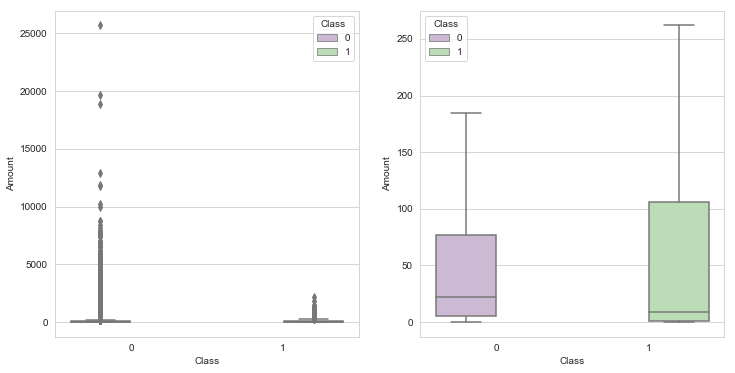

In [109]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=df, palette="PRGn",showfliers=False)

In [110]:
tmp = df[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [111]:
class_1.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

正常的消费拥有更大的平均值，更大的Q1分位和中位数，较小的Q3分位和更大的最大值；盗刷交易则在最大值上明显小于正常消费

接下来结合时间和金额，来探索下不同时间段盗刷交易的金额分布。

In [112]:
fraud = df.loc[df['Class'] == 1]

trace = go.Scatter(
    x = fraud['Hour'],y = fraud['Amount'],
    name="金额",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = '盗刷交易金额',
          xaxis = dict(title = '时间（时）', showticklabels=True), 
          yaxis = dict(title = '金额（美元）'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')

#### 特征关联性

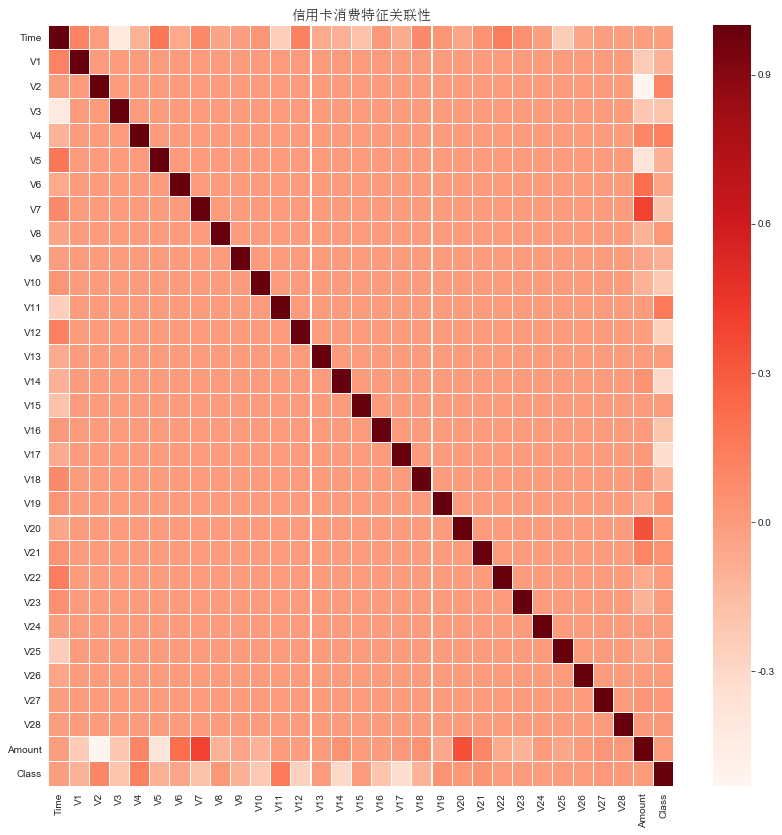

In [113]:
plt.figure(figsize = (14,14))
plt.title(u'信用卡消费特征关联性', fontproperties=myfont)
corr = df.iloc[:,:-1].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds");

如预期，特征V1-V28之间并没有明显的关联性，某些特征与**时间**有一定的关联（**V3**呈反比），或与**金额**有一点的关联（**V7**和**V20**呈正比，**V1**和**V5**呈反比）。

接下来用图来呈现不同类别在正比和反比较为明显的特征上的区别

先从**V20**, **V7**和**金额**开始

E:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



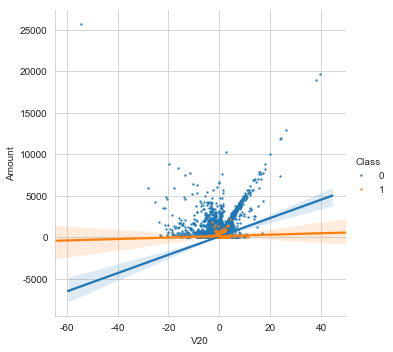

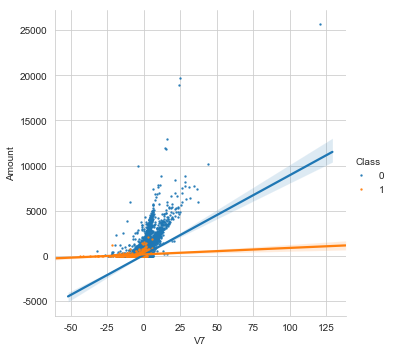

In [95]:
s = sns.lmplot(x='V20', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})

可以发现在呈正比的特征组中，不同类别有着相当大的区别，其中类别为0的具有相对大的正相关性，而类别为1的其特征关联较小

接下来绘制反比关联的图像。

E:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



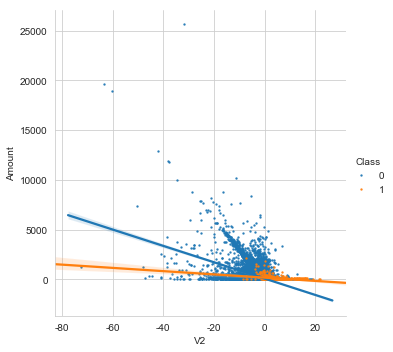

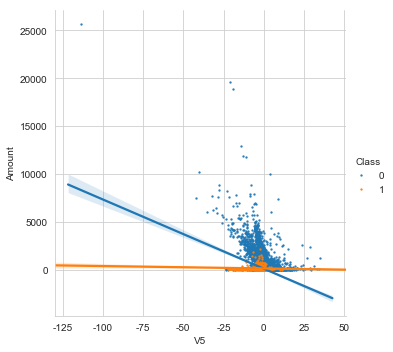

In [96]:
s = sns.lmplot(x='V2', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})

与正比图类似的，类别为0的组有较为明显的负坡，而类别为1的组回归的坡度不明显

#### 特征密度图

<Figure size 432x288 with 0 Axes>

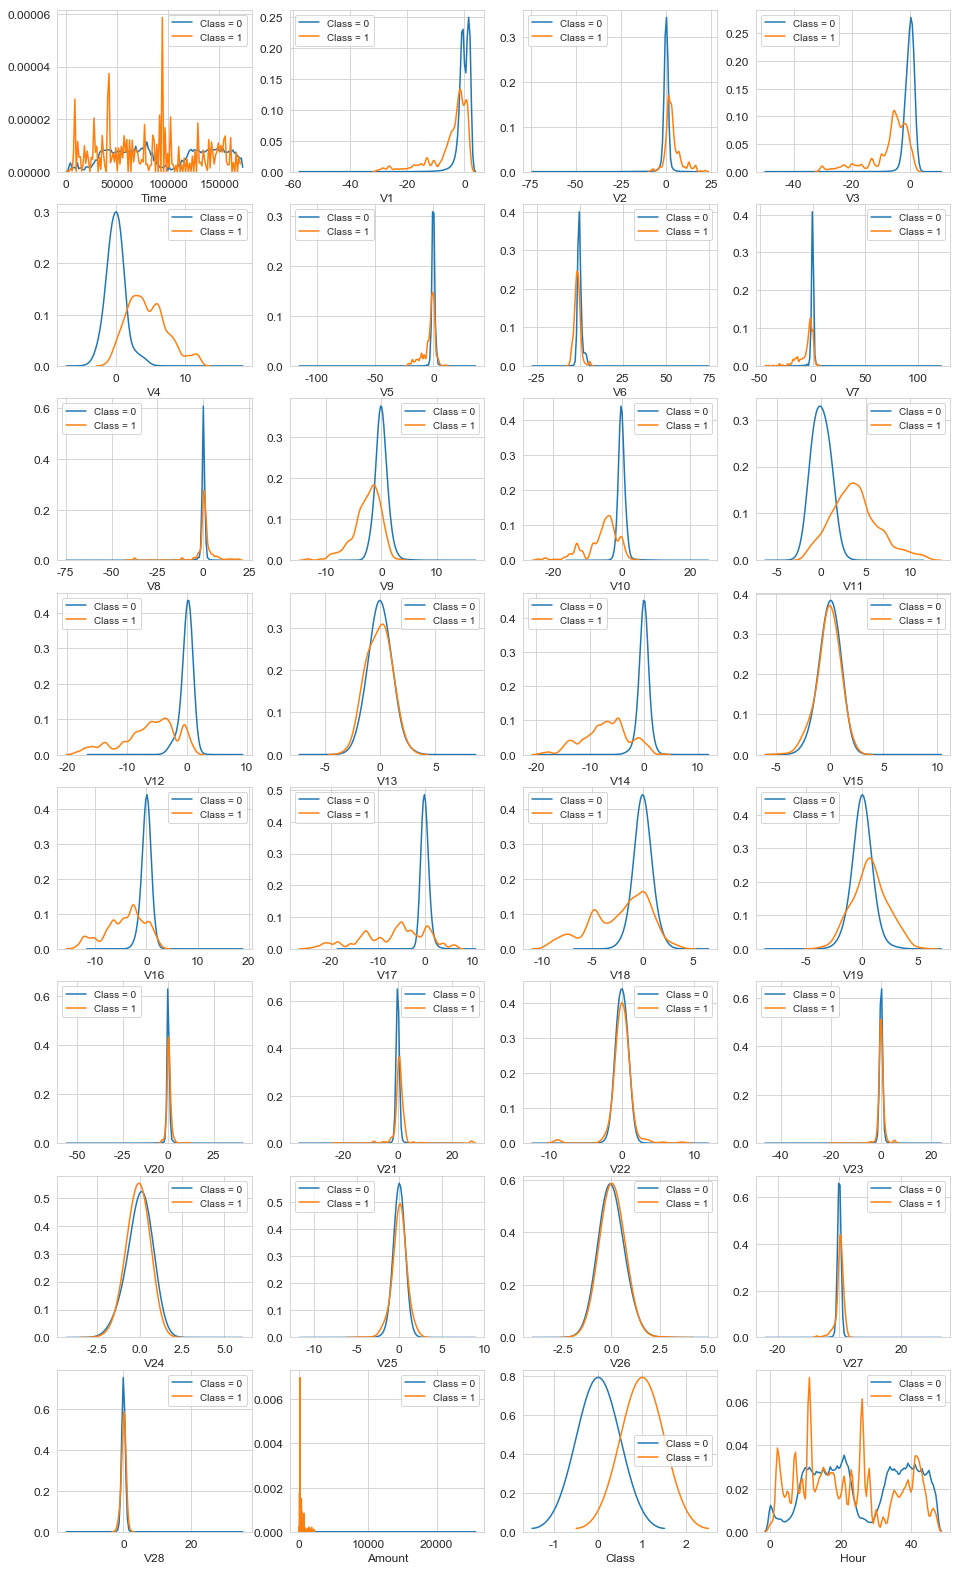

In [114]:
var = df.columns.values

i = 0
t0 = df.loc[df['Class'] == 0]
t1 = df.loc[df['Class'] == 1]

sns.set_style('whitegrid');
plt.figure();
fig, ax = plt.subplots(8,4,figsize=(16,28));

for feature in var:
    i += 1
    plt.subplot(8,4,i);
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0");
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1");
    plt.xlabel(feature, fontsize=12);
    locs, labels = plt.xticks();
    plt.tick_params(axis='both', which='major', labelsize=12);

有些特征我们可以发现不同类别的分布有较为明显的差异，如**V4**，**V11**。而**V12**，**V14**，**V18**则有部分区别，**V1**，**V2**，**V3**和**V10**有些许区别。但例如**V25**，**V26**，**V28**则几乎无区别。

除了时间和金额以外，类别0的各个特征的分布中点几乎在0附近，且形状对称，而类别1的特征则具有不对称（偏斜）的分布。

### <span id=5>5. 模型预测</span>

由于本项目的数据有严重的偏移，使用模型训练会严重影响其训练结果。
因此需要对数据进行前处理减少数据中的不平衡。

偏移数据的前处理分成两种：
1. 低采样——通过减少多样本类的数据提高少样本类数据在整个数据集中的比例
    - 优点是新构成的数据子集会变小，训练速度提升
    - 缺点是多样本类数据的减少会导致信息的缺失，数据子集未必能反应原数据集的情况，更可能出现错误
2. 过采样——通过添加少样本类数据，提高其在整个数据集中的比例
    - 优点是保留了原有数据集的所有信息
    - 缺点是数据集增大，使训练速度变慢

这里我将同时构造低采样和过采样数据集进行计算，制作原训练集、低采样训练集和过采样训练集进行模型训练，比较三者之间对于模型的影响

模型评估使用到的指标为AUC和节费率（SAV）
其中AUC为常见的统计指标，其表示了模型在不同分界情况下，真阳性比与假阳性比的比值的累加，其范围是0到1，越高越好。
节费率可以用下式来表示
$$
节费率 = \frac{全部欺诈损失成本 - 模型判断后的损失成本}{全部欺诈损失成本} * 100%
$$
其含义是计算模型使用后可以帮助发卡行节约多少欺诈损失，这里模型判断后的损失成本并不仅仅包含没被检测出的欺诈案例的成本，还包括发卡行对可能的欺诈交易（但并不一定是）进行确认所付出的额外成本，具体的成本将在后文中讨论。

In [115]:
X = df.iloc[:, :-2] # 特征集
y = df.iloc[:, -2] # 标签集
print(f'0类样本数量{sum(y == 0)}个，占比{sum(y == 0)/len(y)*100:.2f}%')
print(f'1类样本数量{sum(y == 1)}个，占比{sum(y == 1)/len(y)*100:.2f}%')

0类样本数量284315个，占比99.83%
1类样本数量492个，占比0.17%


In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state = RANDOM_STATE)
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

#### 低采样数据构造

In [117]:
rus = imus.RandomUnderSampler(sampling_strategy = 0.052, random_state = 42)
X_us, y_us = rus.fit_resample(X_train, y_train)
print(f'0类样本数量{sum(y_us == 0)}个，占比{sum(y_us == 0)/len(y_us)*100:.2f}%') 
print(f'1类样本数量{sum(y_us == 1)}个，占比{sum(y_us == 1)/len(y_us)*100:.2f}%')

0类样本数量7576个，占比95.06%
1类样本数量394个，占比4.94%


#### 过采样数据构造
过采样数据的构造也包含多种方式：
- 通过直接复制少样本类数据，增加少样本类数据数量
- 通过算法创造类似的少样本类数据，来增加少样本类数据数量

本项目中将使用ADASYN方法来创造人工数据点，其原理是寻找少样本集之间的最近邻点，在最近邻点之间的连线上插值，并赋予该插值微小的抖动来使其并不时纯粹的插值，创造出更“真实”的数据

In [118]:
ada = imos.ADASYN(sampling_strategy=0.052, random_state = 42)
X_os, y_os = ada.fit_resample(X_train, y_train)
print(f'0类样本数量{sum(y_os == 0)}个，占比{sum(y_os == 0)/len(y_os)*100:.2f}%') 
print(f'1类样本数量{sum(y_os == 1)}个，占比{sum(y_os == 1)/len(y_os)*100:.2f}%')

0类样本数量227451个，占比95.04%
1类样本数量11867个，占比4.96%


In [119]:
# 存放模型名称和结果
clfs = []
aucs = []
preds = []

In [120]:
def plot_feat_importance(clf):
    tmp = pd.DataFrame({'feat': df.columns[0:-2], 'feat_importance': clf.feature_importances_
                       })
    tmp = tmp.sort_values(by='feat_importance',ascending=False)
    feat_sum = np.cumsum(tmp.feat_importance)
    
    trace0 = go.Bar(
                x = tmp.feat,
                y = tmp.feat_importance,
                name = '单项特征重要性'
            )
    
    trace1 = go.Scatter(
                x = tmp.feat,
                y = feat_sum,
                mode = 'lines',
                name = '特征重要性之和'
            )
    
    data = [trace0, trace1]
    layout = go.Layout(
            legend=dict(
                    x=0,
                    y=1.1,
                    bgcolor='rgba(255, 255, 255, 0)',
                    bordercolor='rgba(255, 255, 255, 0)'
                    ),
            bargap = 0.15,
            title='特征重要性排序'
    )
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [121]:
# %%time

# rfc = RandomForestClassifier(n_estimators=100,
#                                 n_jobs=NO_JOBS, 
#                     random_state=RANDOM_STATE
#                     )

# rfc.fit(X_train, y_train)
# with open('./models/rfc.pkl', 'wb') as f:
#     pickle.dump(rfc, f)

with open('./models/rfc.pkl', 'rb') as f:
    rfc = pickle.load(f)
y_pred = rfc.predict(X_test)

clfs.append('rfc')
aucs.append(roc_auc_score(y_test, y_pred))
preds.append(y_pred)

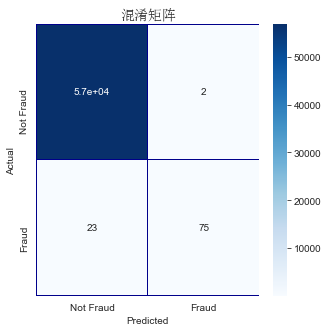

In [122]:
cm = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('混淆矩阵', fontsize=14, fontproperties=myfont);

In [123]:
plot_feat_importance(rfc)

In [124]:
# %%time

# rfc_us = RandomForestClassifier(n_estimators=100,
#                                 n_jobs=NO_JOBS, 
#                     random_state=RANDOM_STATE
#                     )

# rfc_us.fit(X_us, y_us)
# with open('./models/rfc_us.pkl', 'wb') as f:
#     pickle.dump(rfc_us, f)

with open('./models/rfc_us.pkl', 'rb') as f:
    rfc_us = pickle.load(f)
y_us_pred = rfc_us.predict(X_test)

clfs.append('rfc_us')
aucs.append(roc_auc_score(y_test, y_us_pred))
preds.append(y_us_pred)

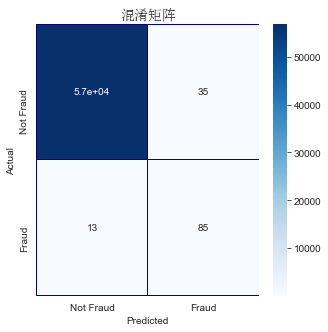

In [125]:
cm = pd.crosstab(y_test, y_us_pred, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('混淆矩阵', fontsize=14, fontproperties=myfont);

In [126]:
plot_feat_importance(rfc_us)

In [127]:
# %%time
# rfc_os = RandomForestClassifier(n_estimators=100,
#                                 n_jobs=NO_JOBS, 
#                     random_state=RANDOM_STATE
#                     )

# rfc_os.fit(X_os, y_os)
# with open('./models/rfc_os.pkl', 'wb') as f:
#     pickle.dump(rfc_os, f)
    
with open('./models/rfc_os.pkl', 'rb') as f:
    rfc_os = pickle.load(f)
y_os_pred = rfc_os.predict(X_test)

clfs.append('rfc_os')
aucs.append(roc_auc_score(y_test, y_os_pred))
preds.append(y_os_pred)

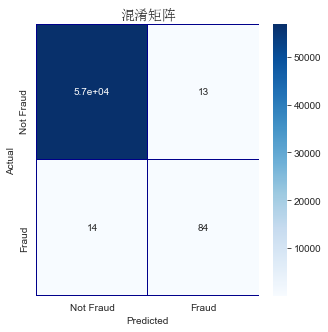

In [128]:
cm = pd.crosstab(y_test, y_os_pred, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('混淆矩阵', fontsize=14, fontproperties=myfont);

In [129]:
plot_feat_importance(rfc_os)

In [130]:
# 为xgboost设置参数
params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'gamma': 0.2,                  
    'lambda': 1,                   
    'subsample': 0.7,              
    'colsample_bytree': 0.7,       
    'silent': 1,
    'eta': 0.007,                  
    'seed': 42,
    'eval_metric': 'auc',
    'nthread': 4,
}

In [131]:
# %%time

# num_round = 5
# xgbc = xgb.XGBClassifier(num_round, **params)
# xgbc.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], 
#         eval_metric='auc',
#         verbose=False)
# with open('./models/xgbc.pkl', 'wb') as f:
#     pickle.dump(xgbc, f)   
    
with open('./models/xgbc.pkl', 'rb') as f:
    xgbc = pickle.load(f)

evals_result = xgbc.evals_result()
xgbc_pred = xgbc.predict(X_test)

clfs.append('xgbc')
aucs.append(evals_result['validation_1']['auc'][-1])
preds.append(xgbc_pred)

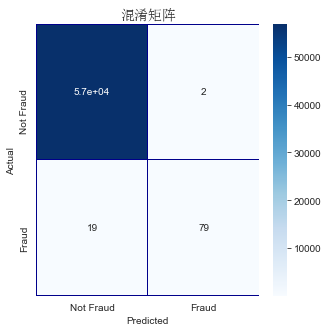

In [132]:
cm = pd.crosstab(y_test, xgbc_pred, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('混淆矩阵', fontsize=14, fontproperties=myfont);

In [133]:
plot_feat_importance(xgbc)

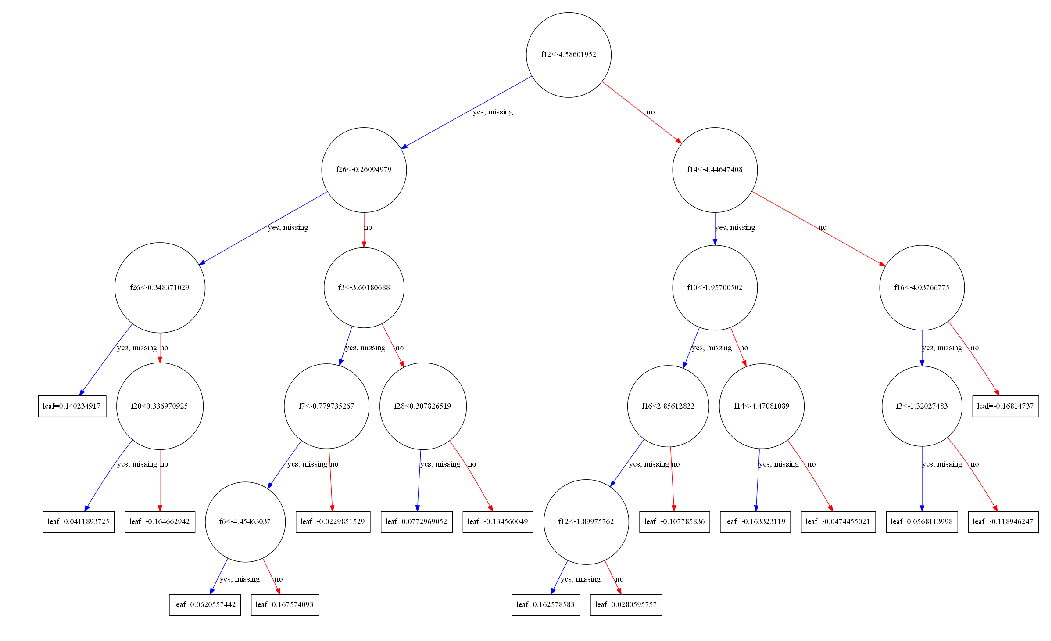

In [134]:
fig, ax = plt.subplots(ncols=1, figsize=(18,26))
xgb.plot_tree(xgbc, num_trees=2, ax=ax);

In [135]:
# %%time

# num_round = 5
# xgb_us = xgb.XGBClassifier(num_round, **params)
# xgb_us.fit(X_us, y_us, eval_set=[(X_us, y_us), (X_test, y_test)], 
#         eval_metric='auc',
#         verbose=False)
# with open('./models/xgb_us.pkl', 'wb') as f:
#     pickle.dump(xgb_us, f)   
    
with open('./models/xgb_us.pkl', 'rb') as f:
    xgb_us = pickle.load(f)

evals_result = xgb_us.evals_result()
xgb_us_pred = xgb_us.predict(X_test)

clfs.append('xgb_us')
aucs.append(evals_result['validation_1']['auc'][-1])
preds.append(xgb_us_pred)

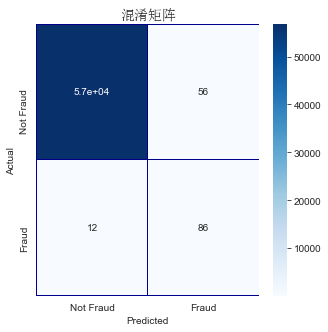

In [136]:
cm = pd.crosstab(y_test, xgb_us_pred, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('混淆矩阵', fontsize=14, fontproperties=myfont);

In [137]:
plot_feat_importance(xgb_us)

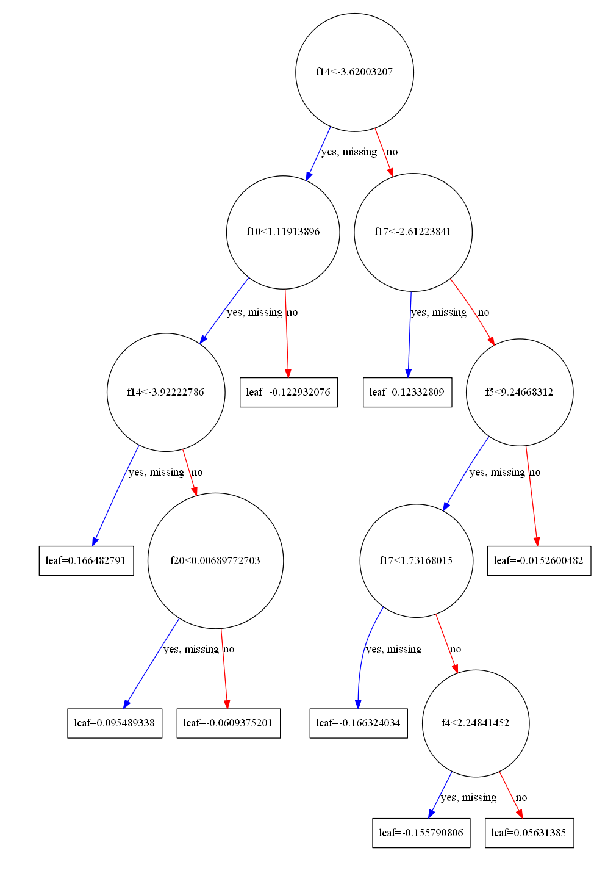

In [139]:
fig, ax = plt.subplots(ncols=1, figsize=(10,16))
xgb.plot_tree(xgb_us, num_trees=2, ax=ax);

In [140]:
# %%time

# xgb_os = xgb.XGBClassifier(**params)
# xgb_os.fit(X_os, y_os, eval_set=[(X_os, y_os), (X_test, y_test)], 
#         eval_metric='auc', verbose=False)
# with open('./models/xgb_os.pkl', 'wb') as f:
#      pickle.dump(xgb_os, f)   
    
with open('./models/xgb_os.pkl', 'rb') as f:
    xgb_os = pickle.load(f)
evals_result = xgb_us.evals_result()
xgb_os_pred = xgb_os.predict(X_test)

clfs.append('xgb_os')
aucs.append(evals_result['validation_1']['auc'][-1])
preds.append(xgb_os_pred)

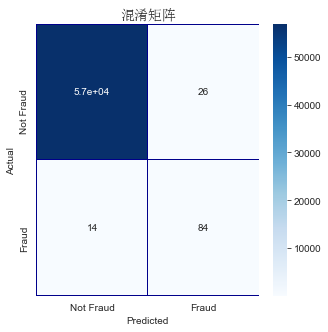

In [141]:
cm = pd.crosstab(y_test, xgb_os_pred, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('混淆矩阵', fontsize=14, fontproperties=myfont);

In [142]:
plot_feat_importance(xgb_os)

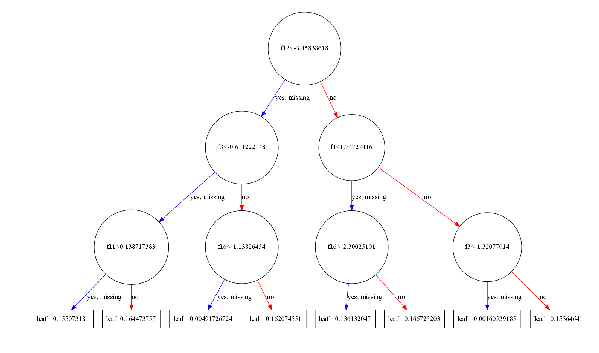

In [143]:
fig, ax = plt.subplots(ncols=1, figsize=(10,16))
xgb.plot_tree(xgb_os, num_trees=2, ax=ax);

#### 案例依赖型成本敏感模型

案例依赖型成本敏感模型的主旨是在保证一定分类准确率的前提下，尽可能减少信用卡发卡机构的损失成本，即信用卡欺诈的成本是否大于发卡机构的审查成本。模型的目标损失将由原来的分类准确率，改为以成本损失最小化为目标。

这里需要对原本的数据增加成本矩阵，成本矩阵表达了该案例在4种可能性（TP,TN,FP,FN）下发卡机构的成本。建立方法：

```
cost_mat = np.ones((样本数, 4))  #cost_mat[FP,FN,TP,TN]
cost_mat[:, 0] = FP成本
cost_mat[:, 1] = FN成本
cost_mat[:, 2] = TP成本
cost_mat[:, 3] = TN成本
```
这里需要根据业务模型对cost_mat进行设定，其中TN由于是正常交易，且被判断正确，cost为0。其中成本最高的是FN成本，即被信用欺诈成功，损失的金额为欺诈的本金和本金的潜在收益。这里本金为原数据Amount项。TP和FP的成本为主动确认是否为欺诈的成本，由于该成本收到其发卡机构内部组织结构和确认手段影响，成本可高可低，因此我们假设3种模式，低cost，中cost和高cost，分别对应cost=1, cost=4和cost=7来研究该部分成本变动对案例依赖模型的影响。

In [144]:
X_mat = ['X_train', 'X_us', 'X_os', 'X_test']

for i in range(len(X_mat)):
    for mat in X_mat:
        locals()['cost'+mat[1:]+str(i+1)] = np.ones((np.shape(eval(mat))[0], 4))
        locals()['cost'+mat[1:]+str(i+1)][:,0] = i * 3 + 1
        locals()['cost'+mat[1:]+str(i+1)][:,1] = eval(mat)[:,-1] * 1.00183
        locals()['cost'+mat[1:]+str(i+1)][:,2] = i * 3 + 1
        locals()['cost'+mat[1:]+str(i+1)][:,3] = 0

分别使用三个表格来保存数据，每个表格对应一种cost情况

In [145]:
# 填充results表格
def fill_results(clfs, preds, cost_test, y_test=y_test):
    results = pd.DataFrame(index=clfs, columns=['AUC', 'SAV'])
    for i in range(len(clfs)):
        results['AUC'].iloc[i] = aucs[i]
        results['SAV'].iloc[i] = savings_score(y_test, preds[i], cost_test)
    return results

results_1 = fill_results(clfs, preds, cost_test1)
results_2 = fill_results(clfs, preds, cost_test2)
results_3 = fill_results(clfs, preds, cost_test3)

In [146]:
def plot_metrics(results, cost_typ):
    x = results.index
    trace1 = go.Bar(
                    x = x,
                    y = results.AUC,
                    text = [round(x,3) for x in results.AUC],
                    textposition = 'auto', 
                    name = 'AUC得分'
            )  
    trace2 = go.Bar(
                    x = x,
                    y = results.SAV,
                    text = [round(x,3) for x in results.SAV], 
                    textposition = 'auto', 
                    name = '节费率'
            )

    layout = go.Layout(
            barmode = 'group',
            title = cost_typ+'成本情况模型比较'
    )
    data = [trace1, trace2]
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [147]:
plot_metrics(results_1, '低')

In [148]:
plot_metrics(results_2, '中')

In [149]:
plot_metrics(results_3, '高')

从现有的4个模型比较，无论是哪种成本矩阵情况，xgb_us和xgb_os都拥有最高的AUC得分，但rfc_os的节费率最高。

#### 成本敏感模型
接下来我们使用成本敏感决策树模型来对数据进行训练，与一般决策树不同的是，其纯度判断的cost并不相等，而是由传入的cost矩阵作为权重，寻求分割后成本的最小化，所有成本敏感模型都用数字编号表示，编号1对应低成本情况，编号2对应中成本情况，编号3对应高成本情况。

In [150]:
# %%time

# for i in range(3):
#     locals()['csdt'+str(i+1)] = CostSensitiveDecisionTreeClassifier()
#     locals()['csdt'+str(i+1)].fit(X_train, y_train, locals()['cost_train'+str(i+1)])
#     with open('./models/csdt'+str(i+1)+'.pkl', 'wb') as f:
#         pickle.dump(locals()['csdt'+str(i+1)], f)

for i in range(3):
    with open('./models/csdt'+str(i+1)+'.pkl', 'rb') as f:
        locals()['csdt'+str(i+1)] = pickle.load(f)
    
    pred = locals()['csdt'+str(i+1)].predict(X_test)
    auc = roc_auc_score(y_test, pred)
    locals()['results_'+str(i+1)].loc['csdt'+str(i+1), 'AUC'] = auc
    sav = savings_score(y_test, pred, eval('cost_test'+str(i+1)))
    locals()['results_'+str(i+1)].loc['csdt'+str(i+1), 'SAV'] = sav

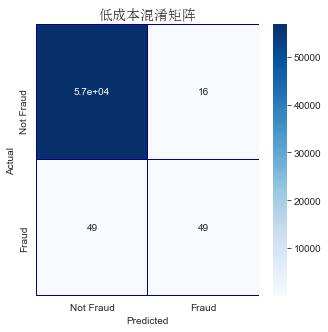

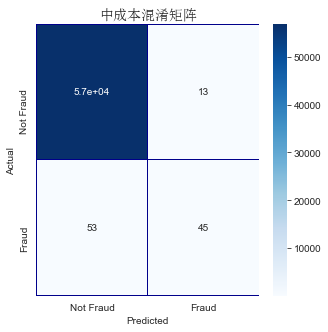

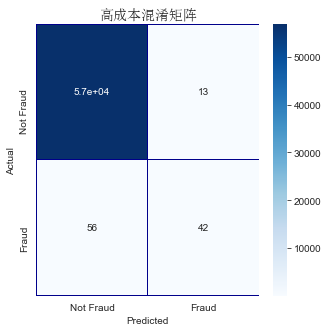

In [151]:
for i in range(3):
    cm = pd.crosstab(y_test, locals()['csdt'+str(i+1)].predict(X_test), rownames=['Actual'], colnames=['Predicted'])
    fig, ax = plt.subplots(ncols=1, figsize=(5,5))
    sns.heatmap(cm, 
                xticklabels=['Not Fraud', 'Fraud'],
                yticklabels=['Not Fraud', 'Fraud'],
                annot=True,ax=ax,
                linewidths=.2,linecolor="Darkblue", cmap="Blues")
    cost_typ = ['低','中','高']
    plt.title(cost_typ[i]+'成本混淆矩阵', fontsize=14, fontproperties=myfont);

In [152]:
# %%time

# for i in range(3):
#     locals()['csdt_us'+str(i+1)] = CostSensitiveDecisionTreeClassifier()
#     locals()['csdt_us'+str(i+1)].fit(X_us, y_us, locals()['cost_us'+str(i+1)])
#     with open('./models/csdt_us'+str(i+1)+'.pkl', 'wb') as f:
#         pickle.dump(locals()['csdt_us'+str(i+1)], f)

for i in range(3):
    with open('./models/csdt_us'+str(i+1)+'.pkl', 'rb') as f:
        locals()['csdt_us'+str(i+1)] = pickle.load(f)
    
    pred = locals()['csdt_us'+str(i+1)].predict(X_test)
    auc = roc_auc_score(y_test, pred)
    locals()['results_'+str(i+1)].loc['csdt_us'+str(i+1), 'AUC'] = auc
    sav = savings_score(y_test, pred, eval('cost_test'+str(i+1)))
    locals()['results_'+str(i+1)].loc['csdt_us'+str(i+1), 'SAV'] = sav

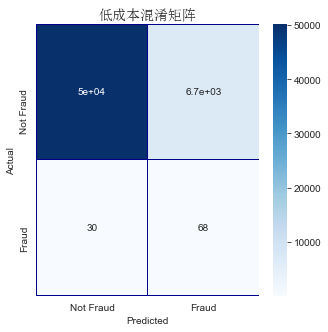

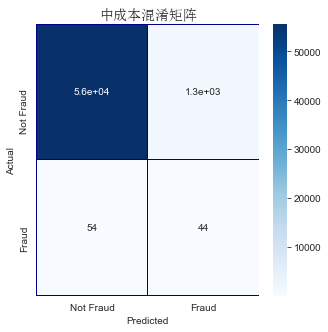

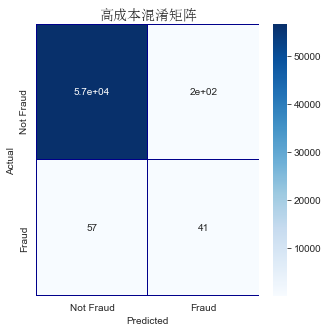

In [153]:
for i in range(3):
    cm = pd.crosstab(y_test, locals()['csdt_us'+str(i+1)].predict(X_test), rownames=['Actual'], colnames=['Predicted'])
    fig, ax = plt.subplots(ncols=1, figsize=(5,5))
    sns.heatmap(cm, 
                xticklabels=['Not Fraud', 'Fraud'],
                yticklabels=['Not Fraud', 'Fraud'],
                annot=True,ax=ax,
                linewidths=.2,linecolor="Darkblue", cmap="Blues")
    cost_typ = ['低','中','高']
    plt.title(cost_typ[i]+'成本混淆矩阵', fontsize=14, fontproperties=myfont);

In [154]:
# %%time

# for i in range(3):
#     locals()['csdt_os'+str(i+1)] = CostSensitiveDecisionTreeClassifier()
#     locals()['csdt_os'+str(i+1)].fit(X_os, y_os, locals()['cost_os'+str(i+1)])
#     with open('./models/csdt_os'+str(i+1)+'.pkl', 'wb') as f:
#         pickle.dump(locals()['csdt_os'+str(i+1)], f)

for i in range(3):
    with open('./models/csdt_os'+str(i+1)+'.pkl', 'rb') as f:
        locals()['csdt_os'+str(i+1)] = pickle.load(f)
    
    pred = locals()['csdt_os'+str(i+1)].predict(X_test)
    auc = roc_auc_score(y_test, pred)
    locals()['results_'+str(i+1)].loc['csdt_os'+str(i+1), 'AUC'] = auc
    sav = savings_score(y_test, pred, eval('cost_test'+str(i+1)))
    locals()['results_'+str(i+1)].loc['csdt_os'+str(i+1), 'SAV'] = sav

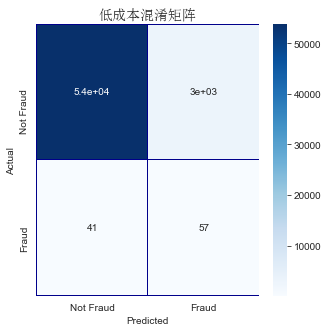

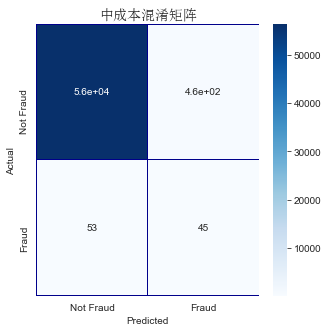

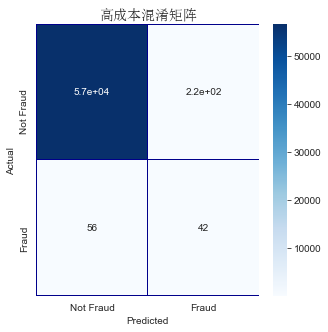

In [155]:
for i in range(3):
    cm = pd.crosstab(y_test, locals()['csdt_os'+str(i+1)].predict(X_test), rownames=['Actual'], colnames=['Predicted'])
    fig, ax = plt.subplots(ncols=1, figsize=(5,5))
    sns.heatmap(cm, 
                xticklabels=['Not Fraud', 'Fraud'],
                yticklabels=['Not Fraud', 'Fraud'],
                annot=True,ax=ax,
                linewidths=.2,linecolor="Darkblue", cmap="Blues")
    cost_typ = ['低','中','高']
    plt.title(cost_typ[i]+'成本混淆矩阵', fontsize=14, fontproperties=myfont);

In [156]:
# 更新2个新模型
plot_metrics(results_1, '低')

In [157]:
plot_metrics(results_2, '中')

In [158]:
plot_metrics(results_3, '高')

在3种成本假设下，我们得到以下观察结果：
- 不论成本如何，AUC得分方面xgb方法表现最好，csdt方法表现最糟糕。
- SAV得分方面，rfc与xgb的结果非常接近，csdt在默认的train数据集上的结果是最好的（优势非常小），但在两种重采样的数据集上表现非常糟糕（最差的两个模型）。
- rfc和xgb的不同训练模型在SAV表现上都非常接近。

我们可以从这些结果中总结一些结论：
1. csdt在原始数据上表现比较好，但是对重采样数据，其原本设置容易导致过拟合，使得在测试集上效果不好。这一点可以通过参数优化、更换成本敏感性随机森林，成本敏感性包内分类模型，或者通过k折模型验证提升
2. 

#### 贝叶斯最低风险
使用贝叶斯最低风险对上述3种成本假设下6个模型进行后剪枝，看是否能达到更好的结果

In [159]:
for i in range(3): 
    for model in locals()['results_'+str(i+1)].index:
        locals()[model+'_BMR'] = BayesMinimumRiskClassifier()
        prob = eval(model).predict_proba(X_test)
        locals()[model+'_BMR'].fit(y_test, prob)
        pred = locals()[model+'_BMR'].predict(prob, eval('cost_test'+str(i+1)))
        auc = (roc_auc_score(y_test, pred))
        sav = savings_score(y_test, pred, eval('cost_test'+str(i+1)))
    
        locals()['results_'+str(i+1)].loc[model+'_BMR', 'AUC'] = auc
        locals()['results_'+str(i+1)].loc[model+'_BMR', 'SAV'] = sav

In [160]:
plot_metrics(results_1, '低')

In [161]:
plot_metrics(results_2, '中')

In [162]:
plot_metrics(results_3, '高')

通过使用贝叶斯最小风险进行后剪枝的模型，rfc和xgb模型普遍都通过下降AUC为代价换取了SAV的提升，AUC的下降幅度两类区别不大，但xgb在SAV上提升更明显，甚至超过了csdt的节费率。而反观csdt，其在AUC上的变化不大。在SAV指标上，原数据集模型变化不明显，重采样模型中均有明显提升。

### 总结
本项目使用了真实的信用卡欺诈数据，通过对数据的清洗、可视化、重构特征，了解了数据的基本规律。
在机器模拟预测部分，本项目的模型采用分为了两部分：普通常规分类模型，案例依赖成本敏感分类模型。
在训练数据的选用上，本项目将训练数据分类为：原训练数据，低采样训练数据，过采样训练数据。
对于案例依赖成本敏感分类模型上，为了寻找不同cost下模型的表现区别，将成本矩阵分成了低成本、中成本和高成本矩阵。
在后剪枝上，所有模型又分为了不使用后剪枝，和使用贝叶斯最小风险后剪枝。

训练的结果表示，xgboost模型非常适合本项目的训练，无论使用哪类训练数据，都可以达到非常好的AUC得分和节费率。成本敏感分类模型，由于本次只试验了csdt模型，且没有特别的调参和分折验证（和xgboost相比），因此并未能充分发挥其能力，效果并不是很理想。但是其模型理念更符合商业操作的实际情况，可以在等待模型训练更成熟的情况下使用。

贝叶斯最低风险剪枝，因为部分理念与成本敏感接近，因此在csdt中的表现并不是非常明显，但对于普通模型可以起到非常好的提高节费率的效果。但是需要注意的是，该剪枝的理论背景是，如果树形决策的分支并不能提升节费率，则会被剪去，因此通常会导致AUC或者说误判率的增加。试想一下，如果在判断一笔1美金的欺诈交易时，因为发卡机构设定的确认该笔交易是否为欺诈的内部成本为2美金，所以并没有被判定为欺诈。但模型没有包含的潜在的损失是，持有该卡的用户收到了欺诈损失，丧失对该卡的信任，转而投身其它发卡机构，而引发的用户离开。因此，没有任何模型是完美的，需要结合业务实际情况，分析欺诈检测的目的（或者多项目的的权重），才能选择最适合的模型。